In [107]:
%matplotlib inline

# Collapsed Gibbs sampler for Generalized Relational Topic Models with Data Augmentation

<div style="display:none">
  $
      \DeclareMathOperator{\dir}{Dirichlet}
      \DeclareMathOperator{\dis}{Discrete}
      \DeclareMathOperator{\normal}{Normal}
      \DeclareMathOperator{\ber}{Bernoulli}
      \DeclareMathOperator{\diag}{diag}
      \DeclareMathOperator{\Betaf}{B}
      \DeclareMathOperator{\Gammaf}{\Gamma}
      \DeclareMathOperator{\PG}{PG}
      \DeclareMathOperator{\v}{vec}
      \newcommand{\norm}[1]{\left\| #1 \right\|}
      \newcommand{\cp}[2]{p \left( #1 \middle| #2 \right)}
      \newcommand{\cN}[2]{\mathscr{N} \left( #1 \middle| #2 \right)}
      \newcommand{\cpsi}[2]{\psi \left( #1 \middle| #2 \right)}
      \newcommand{\cPsi}[2]{\Psi \left( #1 \middle| #2 \right)}
      \newcommand{\etd}[1]{\mathbf{z}^{(#1)}}
      \newcommand{\etdT}[1]{\left. \mathbf{z}^{(#1)} \right.^T}
      \newcommand{\Etd}[2]{\mathbf{z}^{(#1, #2)}}
      \newcommand{\sumetd}{\mathbf{z}}
      \newcommand{\one}{\mathbf{1}}
      \newcommand{\Eta}{H}
      \newcommand{\eHe}{\etdT{d} \Eta \etd{d'}}
  $
</div>

Here is the collapsed Gibbs sampler for Chen et al.'s [generalized relational topic models with data augmentation](http://ijcai.org/papers13/Papers/IJCAI13-192.pdf).  I am building on the [collapsed Gibbs sampler](http://nbviewer.savvysherpa.com/github/gp-0058-clt-at-toys-r-us/relational-topic-models/blob/master/blslda.ipynb) I wrote for binary logistic supervised latent Dirichlet allocation.

The generative model for RTMs is as follows:

$$\begin{align}
\theta^{(d)} &\sim \dir(\alpha) &\text{(topic distribution for document $d \in \{1, \ldots, D\}$)} \\
\phi^{(k)} &\sim \dir(\beta) &\text{(term distribution for topic $k \in \{1, \ldots, K\}$)} \\
z_n^{(d)} \mid \theta^{(d)} &\sim \dis \left( \theta^{(d)} \right) &\text{(topic of $n$th token of document $d$, $n \in \{1, \ldots, N^{(d)}\}$)} \\
w_n^{(d)} \mid \phi^{(z_n^{(d)})} &\sim \dis \left( \phi^{(z_n^{(d)})} \right) &\text{(term of $n$th token of document $d$, $n \in \{1, \ldots, N^{(d)}\}$)} \\
\Eta_{k, k'} &\sim \normal \left( \mu, \nu^2 \right) &\text{(regression coefficients for topic pairs $k, k' \in \{1, \ldots, K\}$)} \\
y^{(d, d')} \mid \Eta, \etd{d}, \etd{d'} &\sim \ber \left(
\frac{ \exp \left( \eHe \right) }{ 1 + \exp \left( \eHe \right) } \right)
&\text{(link indicator for documents $d, d' \in \{1, \ldots, D\}$)}
\end{align}$$

where each token can be any one of $V$ terms in our vocabulary, $\etd{d}$ is the empirical topic distribution of document $d$, and $\circ$ is the Hadamard (element-wise) product.

<img src="http://yosinski.com/mlss12/media/slides/MLSS-2012-Blei-Probabilistic-Topic-Models_084.png" width="600">

<p style='text-align: center; font-style: italic;'>
Plate notation for relational topic models.
<br/>
This diagram should replace $\beta_k$ with $\phi^{(k)}$, and each $\phi^{(k)}$ should be dependent on a single $\beta$.
</p>

Following [Chen et al. 2013](http://ijcai.org/papers13/Papers/IJCAI13-192.pdf), the regularized pseudo-likelihood for the link variable $y^{(d, d')}$, with regularization parameter $b \ge 0$, can be written

$$\begin{align}
\cpsi{y^{(d, d')}}{\Eta, \etd{d}, \etd{d'}, b}
&= \cp{y^{(d, d')}}{\Eta, \etd{d}, \etd{d'}}^b
\\ &= \left( \frac{\exp \left( \eHe \right)^{y^{(d, d')}}}{ 1 + \exp \left( \eHe \right)} \right)^b
\\ &= \frac{\exp \left( b y^{(d, d')} \eHe \right)}
{ \left( \exp \left( -\frac{\eHe}{2} \right) + \exp \left( \frac{\eHe}{2} \right) \right)^b \exp \left( \frac{b}{2} \eHe \right) }
\\ &= 2^{-b} \exp \left( b \left( y^{(d, d')} - \frac{1}{2} \right) \left( \eHe \right) \right) \cosh \left( \frac{ \eHe }{2} \right)^{-b}
\\ &= 2^{-b} \exp \left( b \left( y^{(d, d')} - \frac{1}{2} \right) \left( \eHe \right) \right)
\int_0^\infty \exp \left( -\frac{ \left( \eHe \right)^2 }{2} \omega^{(d, d')} \right)
\cp{\omega^{(d, d')}}{b, 0} d\omega^{(d, d')}
\end{align}$$

where $\omega^{(d, d')}$ is a Polya-Gamma distributed variable with parameters $b = b$ and $c = 0$ (see [Polson et al. 2012](http://arxiv.org/pdf/1205.0310v3.pdf) for details).  This means that, for each pair of documents $d$ and $d'$, the pseudo-likelihood of $y^{(d, d')}$ is actually a mixture of Gaussians with respect to the Polya-Gamma distribution $\PG(b, 0)$.  Therefore, the joint pseudo-likelihood of $y^{(d, d')}$ and $\omega^{(d, d')}$ can be written

$$\cPsi{y^{(d, d')}, \omega^{(d, d')}}{\Eta, \etd{d}, \etd{d'}, b}
= 2^{-b} \exp \left( \kappa^{(d, d')} \zeta^{(d, d')} - \frac{ \omega^{(d, d')} }{2} (\zeta^{(d, d')})^2 \right) \cp{\omega^{(d, d')}}{b, 0}.$$

where $\kappa^{(d, d')} = b(y^{(d, d')} - 1/2)$ and $\zeta^{(d, d')} = \eHe$.  The joint probability distribution can therefore be factored as follows:

$$\begin{align}
\cp{\theta, \phi, z, w, \Eta, y, \omega}{\alpha, \beta, \mu, \nu^2, b}
&= 
\prod_{k=1}^{K} \cp{\phi^{(k)}}{\beta}
\prod_{d=1}^{D} \cp{\theta^{(d)}}{\alpha}
\prod_{n=1}^{N^{(d)}} \cp{z_n^{(d)}}{\theta^{(d)}} \cp{w_n^{(d)}}{\phi^{(z_n^{(d)})}}
\\ & \quad \times \prod_{k_1=1}^{K} \prod_{k_2=1}^{K} \cp{\Eta_{k_1, k_2}}{\mu, \nu^2}
\prod_{d_1=1}^D \prod_{\substack{d_2=1 \\ d_2 \neq d_1}}^D \cPsi{y^{(d_1, d_2)}, \omega^{(d_1, d_2)}}{\Eta, \etd{d_1}, \etd{d_2}, b}
\\ &=
\prod_{k=1}^{K} \frac{\Betaf(b^{(k)} + \beta)}{\Betaf(\beta)} \cp{\phi^{(k)}}{b^{(k)} + \beta}
\prod_{d=1}^{D} \frac{\Betaf(a^{(d)} + \alpha)}{\Betaf(\alpha)} \cp{\theta^{(d)}}{a^{(d)} + \alpha}
\\ &\quad \times
\prod_{k_1=1}^{K} \prod_{k_2=1}^{K} \cN{\Eta_{k_1, k_2}}{\mu, \nu^2} 
\prod_{d_1=1}^D \prod_{\substack{d_2=1 \\ d_2 \neq d_1}}^D 2^{-b} \exp \left( \kappa^{(d_1, d_2)} \zeta^{(d_1, d_2)} - \frac{ \omega^{(d_1, d_2)} }{2} (\zeta^{(d_1, d_2)})^2 \right) \cp{\omega^{(d_1, d_2)}}{b, 0}
\end{align}$$

where $a_k^{(d)}$ is the number of tokens in document $d$ assigned to topic $k$, $b_v^{(k)}$ is the number of tokens equal to term $v$ and assigned to topic $k$, and $\Betaf$ is the [multivariate Beta function](https://en.wikipedia.org/wiki/Beta_function#Multivariate_beta_function). Marginalizing out $\theta$ and $\phi$ by integrating with respect to each $\theta^{(d)}$ and $\phi^{(k)}$ over their respective sample spaces yields

$$\begin{align}
\cp{z, w, \Eta, y, \omega}{\alpha, \beta, \mu, \nu^2, b} &= 
\prod_{k=1}^{K} \frac{\Betaf(b^{(k)} + \beta)}{\Betaf(\beta)}
\prod_{d=1}^{D} \frac{\Betaf(a^{(d)} + \alpha)}{\Betaf(\alpha)}
\\ &\quad\quad \times \prod_{k_1=1}^{K} \prod_{k_2=1}^{K} \cN{\Eta_{k_1, k_2}}{\mu, \nu^2}
\prod_{d_1=1}^D \prod_{\substack{d_2=1 \\ d_2 \neq d_1}}^D 2^{-b} \exp \left( \kappa^{(d_1, d_2)} \zeta^{(d_1, d_2)} - \frac{ \omega^{(d_1, d_2)} }{2} (\zeta^{(d_1, d_2)})^2 \right) \cp{\omega^{(d_1, d_2)}}{b, 0}
\\ &=
\cp{w}{z, \beta} \cp{z}{\alpha} \cp{\Eta}{\mu, \nu^2} \cPsi{y, \omega}{\Eta, z, b}.
\end{align}$$

See my [LDA notebook](http://nbviewer.savvysherpa.com/github/bearnshaw/ml-demos/blob/master/lda_gibbs_sampling_cython.ipynb) for step-by-step details of the previous two calculations.

Our goal is to calculate the posterior distribution

$$\cp{z, \Eta, \omega}{w, y, \alpha, \beta, \mu, \nu^2, b} =
\frac{\cp{z, w, \Eta, y, \omega}{\alpha, \beta, \mu, \nu^2, b}}
{\sum_{z'} \iint \cp{z', w, \Eta', y, \omega{'}}{\alpha, \beta, \mu, \nu^2, b} d\Eta' d\omega{'}}$$

in order to infer the topic assignments $z$ and regression coefficients $\Eta$ from the given term assignments $w$ and link data $y$.  Since calculating this directly is infeasible, we resort to collapsed Gibbs sampling.  The sampler is "collapsed" because we marginalized out $\theta$ and $\phi$, and will estimate them from the topic assignments $z$:

$$\hat\theta_k^{(d)} = \frac{a_k^{(d)} + \alpha_k}{\sum_{k'=1}^K \left(a_{k'}^{(d)} + \alpha_{k'} \right)},\quad
\hat\phi_v^{(k)} = \frac{b_v^{(k)} + \beta_v}{\sum_{v'=1}^V \left(b_{v'}^{(k)} + \beta_{v'} \right)}.$$

Gibbs sampling requires us to compute the full conditionals for each $z_n^{(d)}$, $\omega^{(d, d')}$ and $\Eta_{k, k'}$.  For example, we need to calculate, for all $n$, $d$ and $k$,

$$\begin{align}
\cp{z_n^{(d)} = k}{z \setminus z_n^{(d)}, w, H, y, \omega, \alpha, \beta, \mu, \nu^2, b}
&\propto
\cp{z_n^{(d)} = k, z \setminus z_n^{(d)}, w, H, y, \omega}{\alpha, \beta, \mu, \nu^2, b}
\\ &\propto
\frac{b_{w_n^{(d)}}^{(k)} \setminus z_n^{(d)} + \beta_{w_n^{(d)}}}{ \sum_{v=1}^V \left( b_v^{(k)} \setminus z_n^{(d)} + \beta_v\right)}
\left( a_k^{(d)} \setminus z_n^{(d)} + \alpha_k \right)
\prod_{d_1=1}^{D} \prod_{\substack{d_2=1 \\ d_2 \neq d_1}}^{D} \exp \left( \kappa^{(d_1, d_2)} \zeta^{(d_1, d_2)} - \frac{ \omega^{(d_1, d_2)} }{2} (\zeta^{(d_1, d_2)})^2 \right)
\\ &\propto
\frac{b_{w_n^{(d)}}^{(k)} \setminus z_n^{(d)} + \beta_{w_n^{(d)}}}{ \sum_{v=1}^V \left( b_v^{(k)} \setminus z_n^{(d)} + \beta_v\right)}
\left( a_k^{(d)} \setminus z_n^{(d)} + \alpha_k \right)
\\ &\quad\quad\times
\exp \left( \sum_{\substack{d_1=1 \\ d_1 \neq d}}^{D} \left[ \left( \kappa^{(d_1, d)} - \omega^{(d_1, d)} ( \zeta^{(d_1, d)} \setminus z_n^{(d)}) \right) \frac{H_{:, k}^T \etd{d_1}}{N^{(d)}}
- \frac{ \omega^{(d_1, d)} }{2} \left( \frac{H_{:, k}^T \etd{d_1}}{N^{(d)}} \right)^2 \right] \right.
\\ &\quad\quad\quad\quad +
\left. \sum_{\substack{d_2=1 \\ d_2 \neq d}}^{D} \left[ \left( \kappa^{(d, d_2)} - \omega^{(d, d_2)} ( \zeta^{(d, d_2)} \setminus z_n^{(d)}) \right) \frac{H_{k, :} \etd{d_2}}{N^{(d)}}
- \frac{ \omega^{(d, d_2)} }{2} \left( \frac{H_{k, :} \etd{d_2}}{N^{(d)}} \right)^2 \right] \right)
\end{align}$$

where the "set-minus" notation $\cdot \setminus z_n^{(d)}$ denotes the variable the notation is applied to with the entry $z_n^{(d)}$ removed (again, see my [LDA notebook](http://nbviewer.savvysherpa.com/github/bearnshaw/ml-demos/blob/master/lda_gibbs_sampling_cython.ipynb) for details).  This final proportionality is true since

$$\begin{align}
\prod_{d_1=1}^{D} \prod_{\substack{d_2=1 \\ d_2 \neq d_1}}^{D} \exp \left( \kappa^{(d_1, d_2)} \zeta^{(d_1, d_2)} - \frac{ \omega^{(d_1, d_2)} }{2} (\zeta^{(d_1, d_2)})^2 \right)
&=
\prod_{d_1=1}^{D} \prod_{\substack{d_2=1 \\ d_2 \neq d_1}}^{D} \exp \left( \kappa^{(d_1, d_2)} \left( \zeta^{(d_1, d_2)} \setminus z_n^{(d)} + \Delta_{d, d_1, d_2}^{(k)} \right)
- \frac{ \omega^{(d_1, d_2)} }{2} \left( \zeta^{(d_1, d_2)} \setminus z_n^{(d)} + \Delta_{d, d_1, d_2}^{(k)} \right)^2 \right)
\\ &\propto
\prod_{\substack{d_1=1 \\ d_1 \neq d}}^{D} \exp \left( \kappa^{(d_1, d)} \left( \zeta^{(d_1, d)} \setminus z_n^{(d)} + \Delta_{d, d_1, d}^{(k)} \right)
- \frac{ \omega^{(d_1, d)} }{2} \left( \zeta^{(d_1, d)} \setminus z_n^{(d)} + \Delta_{d, d_1, d}^{(k)} \right)^2 \right)
\\ &\quad\quad\times
\prod_{\substack{d_2=1 \\ d_2 \neq d}}^{D} \exp \left( \kappa^{(d, d_2)} \left( \zeta^{(d, d_2)} \setminus z_n^{(d)} + \Delta_{d, d, d_2}^{(k)} \right)
- \frac{ \omega^{(d, d_2)} }{2} \left( \zeta^{(d, d_2)} \setminus z_n^{(d)} + \Delta_{d, d, d_2}^{(k)} \right)^2 \right)
\\ &\propto
\exp \left( \sum_{\substack{d_1=1 \\ d_1 \neq d}}^{D} \left[ \left( \kappa^{(d_1, d)} - \omega^{(d_1, d)} ( \zeta^{(d_1, d)} \setminus z_n^{(d)}) \right) \frac{H_{:, k}^T (\etd{d_1} \setminus z_n^{(d)})}{N^{(d)}}
- \frac{ \omega^{(d_1, d)} }{2} \left( \frac{H_{:, k}^T (\etd{d_1} \setminus z_n^{(d)})}{N^{(d)}} \right)^2 \right] \right.
\\ &\quad\quad +
\left. \sum_{\substack{d_2=1 \\ d_2 \neq d}}^{D} \left[ \left( \kappa^{(d, d_2)} - \omega^{(d, d_2)} ( \zeta^{(d, d_2)} \setminus z_n^{(d)}) \right) \frac{H_{k, :} (\etd{d_2} \setminus z_n^{(d)})}{N^{(d)}}
- \frac{ \omega^{(d, d_2)} }{2} \left( \frac{H_{k, :} (\etd{d_2} \setminus z_n^{(d)})}{N^{(d)}} \right)^2 \right] \right)
\\ &=
\exp \left( \sum_{\substack{d_1=1 \\ d_1 \neq d}}^{D} \left[ \left( \kappa^{(d_1, d)} - \omega^{(d_1, d)} ( \zeta^{(d_1, d)} \setminus z_n^{(d)}) \right) \frac{H_{:, k}^T \etd{d_1}}{N^{(d)}}
- \frac{ \omega^{(d_1, d)} }{2} \left( \frac{H_{:, k}^T \etd{d_1}}{N^{(d)}} \right)^2 \right] \right.
\\ &\quad\quad +
\left. \sum_{\substack{d_2=1 \\ d_2 \neq d}}^{D} \left[ \left( \kappa^{(d, d_2)} - \omega^{(d, d_2)} ( \zeta^{(d, d_2)} \setminus z_n^{(d)}) \right) \frac{H_{k, :} \etd{d_2}}{N^{(d)}}
- \frac{ \omega^{(d, d_2)} }{2} \left( \frac{H_{k, :} \etd{d_2}}{N^{(d)}} \right)^2 \right] \right)
\end{align}$$

where

$$\Delta_{d, d_1, d_2}^{(k)} = \delta_{d, d_1} \frac{H_{k, :} (\etd{d_2} \setminus z_n^{(d)})}{N^{(d)}} + \delta_{d, d_2} \frac{H_{:, k}^T (\etd{d_1} \setminus z_n^{(d)})}{N^{(d)}},$$

$\delta_{d, d'}$ is the [Kronecker delta](https://en.wikipedia.org/wiki/Kronecker_delta), and $H_{k, :}$ and $H_{:, k}$ are the $k$th row and column of $H$, respectively.  The first proportionality is a result of the fact that $\Delta_{d, d_1, d_2}^{(k)}$ is nonzero only when $d = d_1$ or $d = d_2$.  The last equality follows from the fact that $d \neq d_1$ in the first summation and $d \neq d_2$ in the second.

In order to calculate the full conditional for $H$, let $\eta = (H_{:,1}^T \cdots H_{:, K}^T)^T$ be the vector of concatenated columns of $H$, $Z = (\etd{1, 1} \cdots \etd{D, D})$ be the matrix whose columns are the vectors $\etd{d, d'} = \etd{d'} \otimes \etd{d}$, where $\otimes$ is the [Kronecker product](https://en.wikipedia.org/wiki/Kronecker_product), $\Omega = \diag(\omega^{(1,1)}, \ldots, \omega^{(D,D)})$ be the diagonal matrix whose diagonal entries are $\omega^{(d, d')}$, $I$ be the identity matrix, and $\one$ be the vector of ones, and note that

$$\prod_{k_1=1}^{K} \prod_{k_2=1}^{K} \cN{H_{k_1, k_2}}{\mu, \nu^2} = \cN{\eta}{\mu \one, \nu^2 I}$$
$$\prod_{d_1=1}^{D} \prod_{\substack{d_2=1 \\ d_2 \neq d_1}}^{D} \exp \left( \kappa^{(d_1, d_2)} \zeta^{(d_1, d_2)} - \frac{ \omega^{(d_1, d_2)} }{2} (\zeta^{(d_1, d_2)})^2 \right)
= \exp \left( \eta^T Z \kappa - \frac{1}{2} \eta^T Z \Omega Z^T \eta \right)
\propto \cN{\eta}{(Z \Omega Z^T)^{-1} Z \kappa, (Z \Omega Z^T)^{-1}}.$$

Therefore

$$\begin{align}
\cp{\eta}{z, w, y, \omega, \alpha, \beta, \mu, \nu^2, b}
&\propto
\cp{z, w, \eta, y, \omega}{\alpha, \beta, \mu, \nu^2, b}
\\ &\propto
\cN{\eta}{\mu \one, \nu^2 I} \cN{\eta}{(Z \Omega Z^T)^{-1} Z \kappa, (Z \Omega Z^T)^{-1}}
\\ &\propto
\cN{\eta}{\Sigma \left( \frac{\mu}{\nu^2} \one + Z \kappa \right), \Sigma}
\end{align}$$

where $\Sigma^{-1} = \nu^{-2} I + Z \Omega Z^T$ (see Section 8.1.8 of the [Matrix Cookbook](http://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf)).

We also need to calculate the full conditional for $\omega$.  We calculate

$$\begin{align}
\cp{\omega}{z, w, H, y, \alpha, \beta, \mu, \nu^2, b}
&\propto
\cp{z, w, H, y, \omega}{\alpha, \beta, \mu, \nu^2, b}
\\ &\propto
\prod_{d_1=1}^{D} \prod_{\substack{d_2=1 \\ d_2 \neq d_1}}^{D} \exp \left( - \frac{ \omega^{(d_1, d_2)} }{2} (\zeta^{(d_1, d_2)})^2 \right) \cp{\omega^{(d_1, d_2)}}{b, 0}
\\ &=
\prod_{d_1=1}^{D} \prod_{\substack{d_2=1 \\ d_2 \neq d_1}}^{D} \cp{\omega^{(d_1, d_2)}}{b, \zeta^{(d_1, d_2)}}
\end{align}$$

that is, $\omega^{(d_1, d_2)} \sim \PG(b, \eHe)$ for each pair of documents $d_1$ and $d_2$.  We sample from the Polya-Gamma distribution according to the method of [Polson et al. 2012](http://arxiv.org/pdf/1205.0310.pdf), implemented for Python 3 in this [code repo](https://github.com/Savvysherpa/pypolyagamma).

## Graphical test 

In [40]:
%matplotlib inline

from gRTM.helpers import plot_images
from functools import partial
from sklearn.metrics import (roc_auc_score, roc_curve)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

imshow = partial(plt.imshow, cmap='gray', interpolation='nearest', aspect='auto')
sns.set(style='white')

### Generate topics 

We assume a vocabulary of 25 terms, and create ten "topics", where each topic assigns exactly 5 consecutive terms equal probability.

In [41]:
V = 25
K = 10
N = 100
D = 1000

<Figure size 720x360 with 0 Axes>

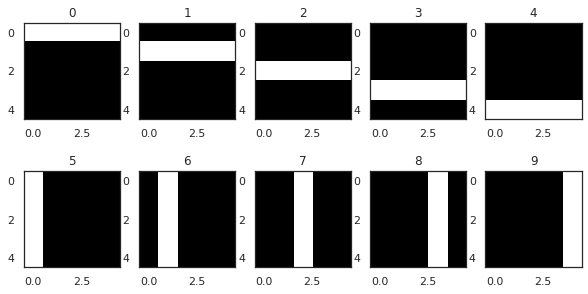

In [42]:
topics = []
topic_base = np.concatenate((np.ones((1, 5)) * 0.2, np.zeros((4, 5))), axis=0).ravel()
for i in range(5):
    topics.append(np.roll(topic_base, i * 5))
topic_base = np.concatenate((np.ones((5, 1)) * 0.2, np.zeros((5, 4))), axis=1).ravel()
for i in range(5):
    topics.append(np.roll(topic_base, i))
topics = np.array(topics)
plt.figure(figsize=(10, 5))
plot_images(plt, topics, (5, 5), layout=(2, 5), figsize=(10, 5))

### Generate documents from topics

We generate 1,000 documents from these 10 topics by sampling 1,000 topic distributions, one for each document, from a Dirichlet distribution with parameter $\alpha = (1, \ldots, 1)$.

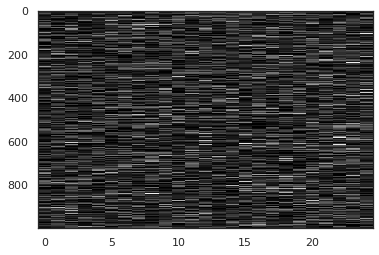

In [43]:
alpha = np.ones(K)
np.random.seed(42)
thetas = np.random.dirichlet(alpha, size=D)
topic_assignments = np.array([np.random.choice(range(K), size=100, p=theta)
                              for theta in thetas])
word_assignments = np.array([[np.random.choice(range(V), size=1, p=topics[topic_assignments[d, n]])[0]
                              for n in range(N)] for d in range(D)])
doc_term_matrix = np.array([np.histogram(word_assignments[d], bins=V, range=(0, V - 1))[0] for d in range(D)])
imshow(doc_term_matrix)

In [45]:
doc_term_matrix.shape

(1000, 25)

### Generate document network

Create a document network from the documents by applying $\psi$ and applying a threshold $\psi_0$.

In [6]:
from itertools import product
from sklearn.model_selection import StratifiedKFold

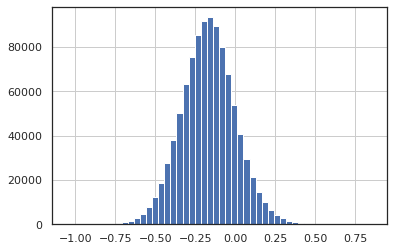

In [7]:
# choose parameter values
mu = 0.
nu2 = 1.
np.random.seed(14)
H = np.random.normal(loc=mu, scale=nu2, size=(K, K))
zeta = pd.DataFrame([(i, j, np.dot(np.dot(thetas[i], H), thetas[j])) for i, j in product(range(D), repeat=2)],
                    columns=('tail', 'head', 'zeta'))
_ = zeta.zeta.hist(bins=50)

In [11]:
zeta[:10]

tail  head      zeta
0     0     0 -0.028691
1     0     1  0.138835
2     0     2 -0.171545
3     0     3 -0.236243
4     0     4  0.031529
5     0     5 -0.138227
6     0     6 -0.493079
7     0     7 -0.081348
8     0     8 -0.165651
9     0     9  0.047437

positive examples 151324 (15.1%)


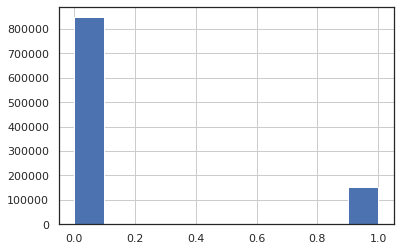

In [12]:
# choose parameter values
zeta['y'] = (zeta.zeta >= 0).astype(int)
# plot histogram of responses
print('positive examples {} ({:.1f}%)'.format(zeta.y.sum(), zeta.y.sum() / D / D * 100))
_ = zeta.y.hist()

In [13]:
y = zeta[['tail', 'head', 'y']].values

In [39]:
doc_term_matrix[0]

array([ 2,  0,  5,  4,  7,  3,  6, 17,  6,  6,  4,  1,  1,  1,  3,  3,  0,
        8,  6,  7,  2,  1,  5,  0,  2])

In [14]:
#skf = StratifiedKFold(y[:, 2], n_folds=100)
skf = StratifiedKFold(n_splits=100)
skf.get_n_splits(y, y[:, 2])

idx = skf.split(y, y[:, 2])
train_idx, test_idx = next(idx)

In [15]:
_, train_idx = next(skf.split(y[:,:1],y[:, 2]))
train_idx.shape

(10000,)

### Estimate parameters

In [16]:
from gRTM.grtm import GRTM

In [17]:
_K = 10
_alpha = alpha[:_K]
_beta = np.repeat(0.01, V)
_mu = mu
_nu2 = nu2
_b = 1.
n_iter = 500
grtm = GRTM(_K, _alpha, _beta, _mu, _nu2, _b, n_iter, seed=42)

In [33]:
y[train_idx]
total1 = 0
total0 = 0
for link in y[train_idx]:
    if link[2] == 1:
        total1 += 1
    else:
        total0 += 1
print(f"1 = {total1}\n0={total0}")

1 = 1513
0=8487


In [35]:
total = total1 + total0
ratio1 = total1/total
ratio0 = total0/total
print(ratio1)
print(ratio0)

0.1513
0.8487


In [25]:
%%time
grtm.fit(doc_term_matrix, y[train_idx])

2021-01-04 10:13:30.636242 start iterations
2021-01-04 10:13:35.626605 0:00:04.990363 elapsed, iter   10, LL -102802.0198, 35.52% change from last
2021-01-04 10:13:40.212850 0:00:09.576608 elapsed, iter   20, LL -51656.5373, 49.75% change from last
2021-01-04 10:13:44.793518 0:00:14.157276 elapsed, iter   30, LL -24603.3166, 52.37% change from last
2021-01-04 10:13:49.393107 0:00:18.756865 elapsed, iter   40, LL -6772.0668, 72.47% change from last
2021-01-04 10:13:53.966685 0:00:23.330443 elapsed, iter   50, LL 4220.1179, 162.32% change from last
2021-01-04 10:13:58.547854 0:00:27.911612 elapsed, iter   60, LL 9541.9908, 126.11% change from last
2021-01-04 10:14:03.126039 0:00:32.489797 elapsed, iter   70, LL 13176.2402, 38.09% change from last
2021-01-04 10:14:07.713546 0:00:37.077304 elapsed, iter   80, LL 14937.5582, 13.37% change from last
2021-01-04 10:14:12.299330 0:00:41.663088 elapsed, iter   90, LL 16168.6852, 8.24% change from last
2021-01-04 10:14:16.894906 0:00:46.258664 el

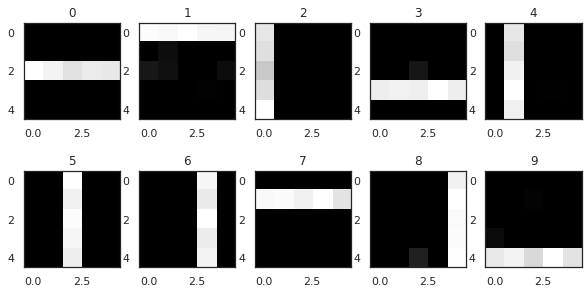

In [34]:
plot_images(plt, grtm.phi, (5, 5), (2, 5), figsize=(10, 5))

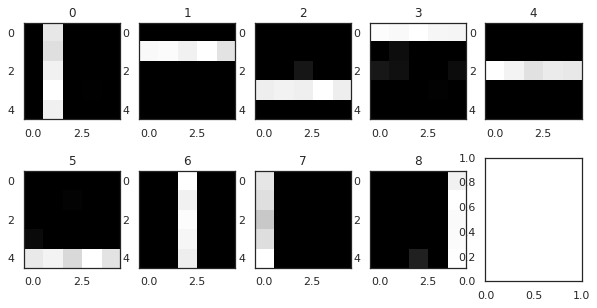

In [123]:
topic_order = [4, 7, 3, 1, 0, 9, 5, 2, 8]
plot_images(plt, grtm.phi[topic_order], (5, 5), (2, 5), figsize=(10, 5))

24065.947223737574


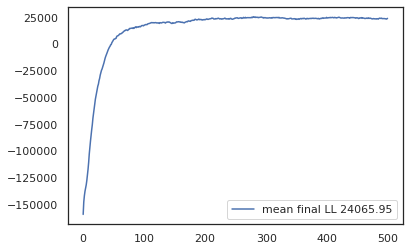

In [163]:
burnin = -1
mean_final_lL = grtm.loglikelihoods[burnin:].mean()
print(mean_final_lL)
plt.plot(grtm.loglikelihoods, label='mean final LL {:.2f}'.format(mean_final_lL))
plt.legend()

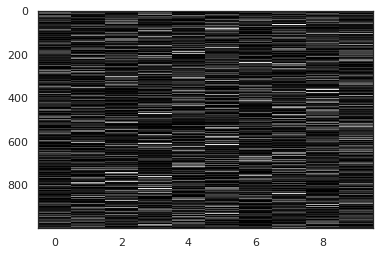

In [125]:
imshow(grtm.theta)

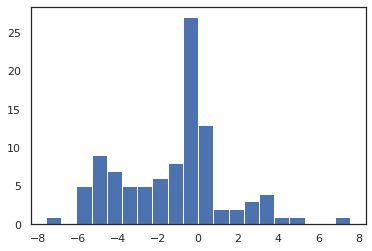

In [205]:
H_pred = grtm.H[:].mean(axis=0)
_ = plt.hist(H_pred.ravel(), bins=20)

In [209]:
H_pred

array([[ 2.8370732 , -4.1038119 , -1.93225466,  3.39955765,  7.59404792,
         2.85266594, -1.86883795,  0.40947277, -5.19484435, -2.0803201 ],
       [-1.22194156, -5.27558857, -5.12717836, -3.36226049,  0.94461811,
        -1.68086659, -5.52597597, -4.07643192, -5.27381449, -5.69693485],
       [ 0.21195283, -0.76665102, -0.52791486, -0.3641166 ,  0.47003904,
        -0.12384493, -0.50159681, -0.49619069, -0.68796052, -0.41160538],
       [-0.18111306, -5.80858516, -4.91329813, -4.08103546,  2.64008323,
        -3.11689208, -5.19729255, -3.93899271, -5.93265914, -4.69789584],
       [ 0.22915157, -0.53006392, -0.19613929, -0.06932364,  0.42294484,
         0.13953985, -0.10708746, -0.28624865, -0.53483246, -0.04535585],
       [-0.0809154 , -1.17071484, -0.70156315,  0.17117958,  0.62963314,
         0.11470913, -0.82657766,  0.29369322, -1.4856239 , -0.95331321],
       [-0.34063324, -0.70323523, -0.62007132, -0.50563029,  0.10796348,
        -0.07100713, -0.59852942, -0.54568466

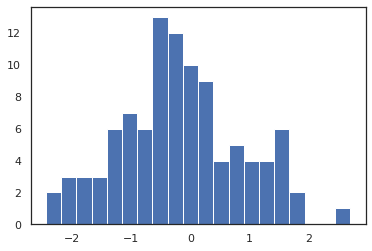

In [127]:
_ = plt.hist(H.ravel(), bins=20)

### Predict edges on pairs of test documents

Create 1,000 test documents using the same generative process as our training documents.

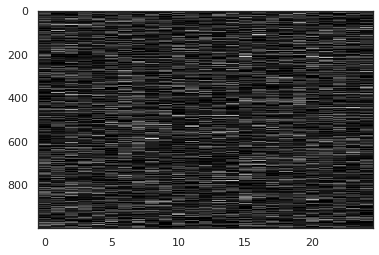

In [128]:
np.random.seed(42^2)
thetas_test = np.random.dirichlet(alpha, size=D)
topic_assignments_test = np.array([np.random.choice(range(K), size=100, p=theta)
                                   for theta in thetas_test])
word_assignments_test = np.array([[np.random.choice(range(V), size=1, p=topics[topic_assignments_test[d, n]])[0]
                                   for n in range(N)] for d in range(D)])
doc_term_matrix_test = np.array([np.histogram(word_assignments_test[d], bins=V, range=(0, V - 1))[0] for d in range(D)])
imshow(doc_term_matrix_test)

Learn their topic distributions using the model trained on the training documents, then calculate the actual and predicted values of $\psi$.  For predicted $\psi$, estimate $\eta$ as the mean of our samples of $\eta$ after burn-in.

In [129]:
def bern_param(theta1, theta2, H):
    zeta = np.dot(np.dot(theta1, H), theta2)
    return np.exp(zeta) / (1 + np.exp(zeta))

In [130]:
thetas_test_grtm = grtm.transform(doc_term_matrix_test)
p_test = np.zeros(D * D)
p_test_grtm = np.zeros(D * D)
for n, i in enumerate(product(range(D), range(D))):
    p_test[n] = bern_param(thetas_test[i[0]], thetas_test[i[1]], H)
    p_test_grtm[n] = bern_param(thetas_test_grtm[i[0]], thetas_test_grtm[i[1]], H_pred)   

Measure the goodness of our prediction by the [area under the associated ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve).

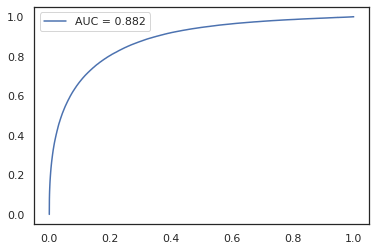

In [131]:
y_test = (p_test > 0.5).astype(int)
y_grtm = p_test_grtm
fpr, tpr, _ = roc_curve(y_test, y_grtm)
plt.plot(fpr, tpr, label=('AUC = {:.3f}'.format(roc_auc_score(y_test, y_grtm))))
_ = plt.legend(loc='best')

In [132]:
doc_term_matrix_test.shape

(1000, 25)

In [161]:
bern_param(grtm.phi[:,12],thetas_test_grtm[0],H_pred)

0.4765798716770462

In [200]:
grtm.H[-1:]

array([[[ 2.82105067, -4.26120303, -2.28262841,  3.56973947,
          8.26555537,  2.75227851, -1.81116151,  0.1341621 ,
         -5.08972141, -2.16098079],
        [-1.26752935, -5.64626419, -5.2601661 , -4.60723004,
          1.02636232, -1.954875  , -5.45715269, -3.89879331,
         -6.0735059 , -6.23366327],
        [ 0.72192846, -0.26244423,  0.0118123 ,  0.22623921,
          1.0992153 ,  0.49077582,  0.1051889 , -0.033389  ,
         -0.22656015,  0.30443968],
        [ 0.20508757, -6.23862842, -5.40066657, -4.40634063,
          3.2825149 , -2.87504889, -5.08485531, -4.01538412,
         -6.07482568, -5.0718483 ],
        [ 0.11234583, -0.1811223 ,  0.03372374,  0.12208667,
          0.29606755,  0.21200257,  0.03066066,  0.01857096,
         -0.25044153,  0.05371094],
        [ 0.36623869, -0.35811364, -0.14948565,  0.48754422,
          0.86806928,  0.43767147, -0.25224127,  0.58758006,
         -0.51726735, -0.35935996],
        [-0.1729242 , -0.74752306, -0.61340427, -0.5

In [206]:
grtm.H[-1].mean(axis=0)

array([ 0.52641974, -2.98234433, -2.16524553, -0.35535383,  2.93828498,
        0.2205748 , -2.0771819 , -0.84046799, -3.55697969, -2.24896628])

In [211]:
thetas_test_grtm[3]

array([0.00651865, 0.27876064, 0.06677252, 0.13646347, 0.15271093,
       0.07754246, 0.07374021, 0.04783272, 0.06814667, 0.09151174])

In [150]:
grtm.phi[:,0]

array([1.04023093e-06, 1.91427948e-01, 2.03567256e-01, 9.42396042e-07,
       1.03613522e-06, 1.03239128e-06, 1.04174805e-06, 9.53175265e-07,
       9.70473348e-07, 1.00722685e-06])

In [189]:
len(doc_term_matrix[0])

25

In [197]:
grtm.H[-1].shape

(10, 10)